<a href="https://colab.research.google.com/github/metropooping/LSTM-EV-Load-Forecasting/blob/main/LSTM_WEEKLY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA LOADING**

In [ ]:
from google.colab import files

# Upload kaggle.json
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install --upgrade pip
!pip install kaggle

# Make directory and copy token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
!kaggle datasets download -d anshtanwar/residential-ev-chargingfrom-apartment-buildings

Dataset URL: https://www.kaggle.com/datasets/anshtanwar/residential-ev-chargingfrom-apartment-buildings
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/1.10M [00:00<?, ?B/s]
100% 1.10M/1.10M [00:00<00:00, 665MB/s]


In [ ]:
!unzip "residential-ev-chargingfrom-apartment-buildings.zip"

Archive:  residential-ev-chargingfrom-apartment-buildings.zip
  inflating: archive (34)/Dataset 1_EV charging reports.csv  
  inflating: archive (34)/Dataset 2_Hourly EV loads - Per user.csv  
  inflating: archive (34)/Dataset 3a_Hourly EV loads - Aggregated private.csv  
  inflating: archive (34)/Dataset 3b_Hourly EV loads - Aggregated shared.csv  
  inflating: archive (34)/Dataset 5_AMS data from garage Bl2.csv  
  inflating: archive (34)/Dataset 6_Local traffic distribution.csv  
  inflating: archive (34)/Norway_Trondheim_ExactLoc_Weather.csv  


In [ ]:
%cd "archive (34)"

/content/archive (34)


In [ ]:
!ls

'Dataset 1_EV charging reports.csv'
'Dataset 2_Hourly EV loads - Per user.csv'
'Dataset 3a_Hourly EV loads - Aggregated private.csv'
'Dataset 3b_Hourly EV loads - Aggregated shared.csv'
'Dataset 5_AMS data from garage Bl2.csv'
'Dataset 6_Local traffic distribution.csv'
 Norway_Trondheim_ExactLoc_Weather.csv


# Preprocessing

## EV LOAD WEEKLY

In [ ]:
# Reload the raw dataset with correct delimiter
import pandas as pd

df1 = pd.read_csv("Dataset 1_EV charging reports.csv", delimiter=';')

# Confirm reset
df1.head()


,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


In [ ]:
# Reload the dataset properly
df1 = pd.read_csv("Dataset 1_EV charging reports.csv", delimiter=';')

# Replace commas with periods in El_kWh column
df1['El_kWh'] = df1['El_kWh'].str.replace(',', '.').astype(float)

# Convert Start_plugin to datetime
df1['Start_plugin'] = pd.to_datetime(df1['Start_plugin'], dayfirst=True)

# Filter for 2019 data
df_filtered = df1[(df1['Start_plugin'] >= '2019-01-01') & (df1['Start_plugin'] < '2020-01-01')].copy()

# Create 'week' column
df_filtered['week'] = df_filtered['Start_plugin'].dt.to_period('W')

# Group and sum by week
weekly_load = df_filtered.groupby('week')['El_kWh'].sum().reset_index()
weekly_load.rename(columns={'El_kWh': 'ev_load_kWh'}, inplace=True)
weekly_load['week'] = weekly_load['week'].astype(str)

# Display result
weekly_load

,week,ev_load_kWh
0,2018-12-31/2019-01-06,103.24
1,2019-01-07/2019-01-13,224.91
2,2019-01-14/2019-01-20,328.54
3,2019-01-21/2019-01-27,361.84
4,2019-01-28/2019-02-03,347.01
5,2019-02-04/2019-02-10,192.84
6,2019-02-11/2019-02-17,434.59
7,2019-02-18/2019-02-24,438.24
8,2019-02-25/2019-03-03,698.59
9,2019-03-04/2019-03-10,604.56


## Weather Processing

In [ ]:
# Load the weather dataset
weather_df = pd.read_csv("Norway_Trondheim_ExactLoc_Weather.csv")

# View columns and sample data
print(weather_df.columns)
weather_df.head()


Index(['Unnamed: 0', 'clouds', 'datetime', 'dewpt', 'dhi', 'dni', 'ghi',
       'max_dhi', 'max_dni', 'max_ghi', 'max_temp', 'max_temp_ts', 'max_uv',
       'max_wind_dir', 'max_wind_spd', 'max_wind_spd_ts', 'min_temp',
       'min_temp_ts', 'precip', 'precip_gpm', 'pres', 'revision_status', 'rh',
       'slp', 'snow', 'snow_depth', 'solar_rad', 't_dhi', 't_dni', 't_ghi',
       't_solar_rad', 'temp', 'ts', 'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')


,Unnamed: 0,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,66,2018-12-01,-1.7,5,40,6,34,288,48,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,1,64,2018-12-02,-2.8,5,38,6,33,281,46,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,2,100,2018-12-03,-0.7,5,37,5,33,273,44,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,3,93,2018-12-04,-0.5,5,35,5,32,266,42,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,4,87,2018-12-05,-1.9,5,34,5,32,260,41,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [ ]:
# Step 1: Convert 'datetime' to datetime format
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])

# Step 2: Filter for the full weeks in 2019 (match EV weekly load)
weather_2019 = weather_df[(weather_df['datetime'] >= '2018-12-31') &
                          (weather_df['datetime'] < '2020-01-01')].copy()

# Step 3: Create 'week' column
weather_2019['week'] = weather_2019['datetime'].dt.to_period('W')

# Step 4: Convert needed columns to numeric (if object due to commas or missing values)
for col in ['temp', 'precip_gpm', 'rh', 'wind_spd']:
    weather_2019[col] = pd.to_numeric(weather_2019[col], errors='coerce')

# Step 5: Group by week and calculate stats
weekly_weather = weather_2019.groupby('week').agg({
    'temp': 'mean',
    'precip_gpm': 'sum',
    'rh': 'mean',
    'wind_spd': 'mean'
}).reset_index()

# Step 6: Clean 'week' for merging
weekly_weather['week'] = weekly_weather['week'].astype(str)

# Step 7: Display
weekly_weather


,week,temp,precip_gpm,rh,wind_spd
0,2018-12-31/2019-01-06,4.057143,61.5,88.514286,3.814286
1,2019-01-07/2019-01-13,1.128571,30.5,85.814286,3.771429
2,2019-01-14/2019-01-20,-3.885714,22.5,87.028571,2.985714
3,2019-01-21/2019-01-27,-7.271429,0.0,77.757143,1.928571
4,2019-01-28/2019-02-03,-4.900000,0.0,65.228571,2.342857
5,2019-02-04/2019-02-10,-3.385714,5.0,83.228571,1.814286
6,2019-02-11/2019-02-17,2.814286,30.0,79.728571,3.414286
7,2019-02-18/2019-02-24,3.157143,12.5,75.871429,2.685714
8,2019-02-25/2019-03-03,2.657143,40.5,81.728571,3.928571
9,2019-03-04/2019-03-10,-4.114286,0.0,77.200000,2.742857


## Traffic Preprocessing

In [ ]:
traffic_df = pd.read_csv("Dataset 6_Local traffic distribution.csv", delimiter=';')

# Preview columns
print(traffic_df.columns)
traffic_df.head()


Index(['Date_from', 'Date_to', 'KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK',
       'MOHOLT RAMPE 2', 'Jonsvannsveien vest for Steinanvegen'],
      dtype='object')


,Date_from,Date_to,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen
0,01.12.2018 00:00,01.12.2018 01:00,639,0,0,4,144
1,01.12.2018 01:00,01.12.2018 02:00,487,153,115,21,83
2,01.12.2018 02:00,01.12.2018 03:00,408,85,75,10,69
3,01.12.2018 03:00,01.12.2018 04:00,282,89,56,8,39
4,01.12.2018 04:00,01.12.2018 05:00,165,64,34,3,25


In [ ]:
# Convert Date_from to datetime
traffic_df['Date_from'] = pd.to_datetime(traffic_df['Date_from'], dayfirst=True, errors='coerce')

# Filter for 2019 only
traffic_2019 = traffic_df[(traffic_df['Date_from'] >= '2019-01-01') &
                          (traffic_df['Date_from'] < '2020-01-01')].copy()

# Create week column
traffic_2019['week'] = traffic_2019['Date_from'].dt.to_period('W')

# Convert all traffic columns to numeric (in case of missing/dirty data)
traffic_columns = ['KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK', 'MOHOLT RAMPE 2', 'Jonsvannsveien vest for Steinanvegen']
for col in traffic_columns:
    traffic_2019[col] = pd.to_numeric(traffic_2019[col], errors='coerce')

# Sum across all locations
traffic_2019['total_traffic'] = traffic_2019[traffic_columns].sum(axis=1)

# Aggregate weekly
weekly_traffic = traffic_2019.groupby('week')['total_traffic'].sum().reset_index()
weekly_traffic['week'] = weekly_traffic['week'].astype(str)

# Show result
weekly_traffic


,week,total_traffic
0,2018-12-31/2019-01-06,415131.0
1,2019-01-07/2019-01-13,579422.0
2,2019-01-14/2019-01-20,570780.0
3,2019-01-21/2019-01-27,581187.0
4,2019-01-28/2019-02-03,589061.0
5,2019-02-04/2019-02-10,586204.0
6,2019-02-11/2019-02-17,583693.0
7,2019-02-18/2019-02-24,547209.0
8,2019-02-25/2019-03-03,595871.0
9,2019-03-04/2019-03-10,599635.0


## Merged Dataset

In [ ]:
# Merge the datasets
merged_df = pd.merge(weekly_load, weekly_weather, on='week', how='inner')
merged_df = pd.merge(merged_df, weekly_traffic, on='week', how='inner')

# View full merged dataset
pd.set_option('display.max_rows', None)
print("Merged dataset shape:", merged_df.shape)
display(merged_df)


Merged dataset shape: (53, 7)


,week,ev_load_kWh,temp,precip_gpm,rh,wind_spd,total_traffic
0,2018-12-31/2019-01-06,103.24,4.057143,61.5,88.514286,3.814286,415131.0
1,2019-01-07/2019-01-13,224.91,1.128571,30.5,85.814286,3.771429,579422.0
2,2019-01-14/2019-01-20,328.54,-3.885714,22.5,87.028571,2.985714,570780.0
3,2019-01-21/2019-01-27,361.84,-7.271429,0.0,77.757143,1.928571,581187.0
4,2019-01-28/2019-02-03,347.01,-4.900000,0.0,65.228571,2.342857,589061.0
5,2019-02-04/2019-02-10,192.84,-3.385714,5.0,83.228571,1.814286,586204.0
6,2019-02-11/2019-02-17,434.59,2.814286,30.0,79.728571,3.414286,583693.0
7,2019-02-18/2019-02-24,438.24,3.157143,12.5,75.871429,2.685714,547209.0
8,2019-02-25/2019-03-03,698.59,2.657143,40.5,81.728571,3.928571,595871.0
9,2019-03-04/2019-03-10,604.56,-4.114286,0.0,77.200000,2.742857,599635.0


In [ ]:
import numpy as np

# STEP 1: Add week number (1 to 53)
merged_df['week_num'] = np.arange(1, len(merged_df) + 1)

# STEP 2: Add delta_traffic (week-to-week change in traffic)
merged_df['delta_traffic'] = merged_df['total_traffic'].diff().fillna(0)

# STEP 3: Add holiday_flag (mark Week 52 as holiday)
merged_df['holiday_flag'] = (merged_df['week_num'] == 52).astype(int)

# Check if the new features are added correctly
print("Updated dataset with engineered features:")
display(merged_df.tail(52))  # show last 10 rows


Updated dataset with engineered features:


,week,ev_load_kWh,temp,precip_gpm,rh,wind_spd,total_traffic,week_num,delta_traffic,holiday_flag
1,2019-01-07/2019-01-13,224.91,1.128571,30.5,85.814286,3.771429,579422.0,2,164291.0,0
2,2019-01-14/2019-01-20,328.54,-3.885714,22.5,87.028571,2.985714,570780.0,3,-8642.0,0
3,2019-01-21/2019-01-27,361.84,-7.271429,0.0,77.757143,1.928571,581187.0,4,10407.0,0
4,2019-01-28/2019-02-03,347.01,-4.900000,0.0,65.228571,2.342857,589061.0,5,7874.0,0
5,2019-02-04/2019-02-10,192.84,-3.385714,5.0,83.228571,1.814286,586204.0,6,-2857.0,0
6,2019-02-11/2019-02-17,434.59,2.814286,30.0,79.728571,3.414286,583693.0,7,-2511.0,0
7,2019-02-18/2019-02-24,438.24,3.157143,12.5,75.871429,2.685714,547209.0,8,-36484.0,0
8,2019-02-25/2019-03-03,698.59,2.657143,40.5,81.728571,3.928571,595871.0,9,48662.0,0
9,2019-03-04/2019-03-10,604.56,-4.114286,0.0,77.200000,2.742857,599635.0,10,3764.0,0
10,2019-03-11/2019-03-17,891.59,-1.500000,3.5,72.357143,2.728571,606061.0,11,6426.0,0


# Modelling/Forecasting

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Activation

# === Step 1: Define Features and Target (Assume engineered features already exist) ===
features = [
    'temp', 'rh', 'total_traffic',
    'week_num', 'delta_traffic', 'holiday_flag'
]
target = 'ev_load_kWh'


scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(merged_df[features])
y_scaled = scaler_y.fit_transform(merged_df[[target]])


lookback = 10
X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i - lookback:i])
    y_seq.append(y_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# === Step 4: Train on ALL data ===
X_train, y_train = X_seq, y_seq

# === Step 5: Build the Model ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, len(features))))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.add(Dense(1))
model.add(Activation('relu'))

# === Step 6: Train ===
history = model.fit(X_train, y_train, epochs=200, verbose=1)

# === Step 7: Predict and Inverse Transform ===
y_pred_scaled = model.predict(X_train)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_actual = scaler_y.inverse_transform(y_train)

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"MAE: {mae:.2f} kWh")
print(f"RMSE: {rmse:.2f} kWh")



Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.2314
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0536 
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.1115
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0546
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0458
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0489
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0459
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0347 
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0361
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0380
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0267
Epoch 12/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0263 
Epoch 13/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0278
Epoch 14/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0222 
Epoch 15/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0278
Epoch 16/200
2/2 ━━━━━━━━━━

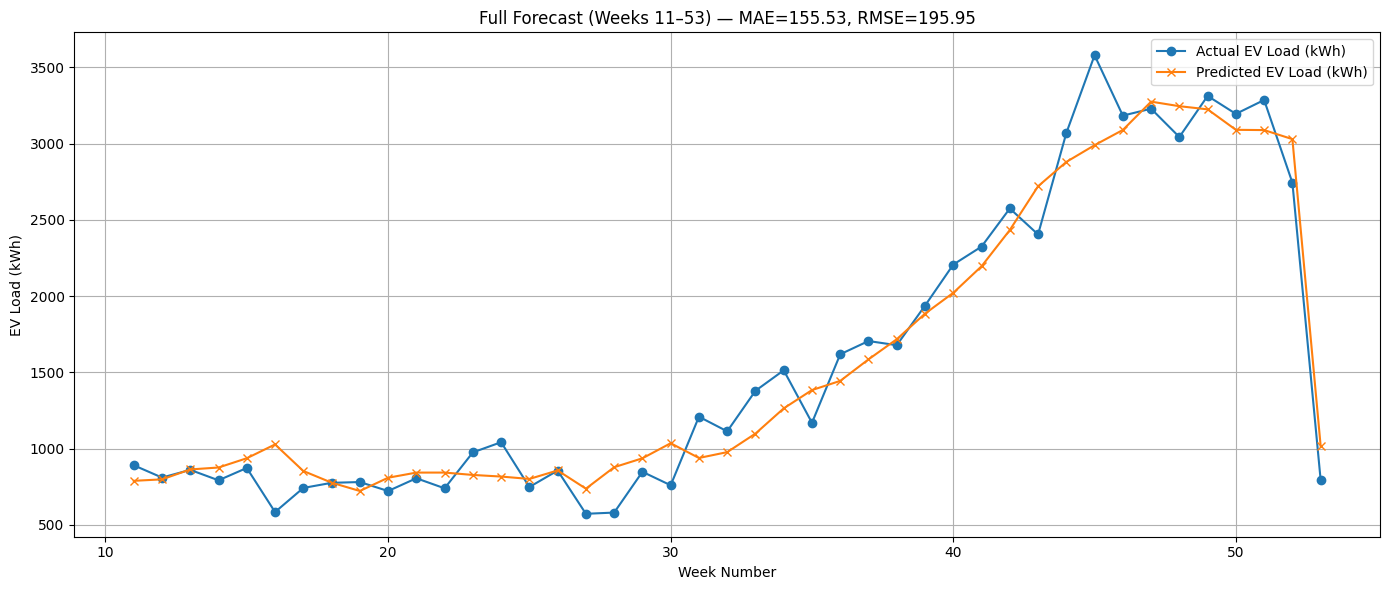

In [ ]:
# === Step 9: Plot ===
weeks = np.arange(lookback + 1, len(merged_df) + 1)  # Match week numbers to actual weeks
plt.figure(figsize=(14, 6))
plt.plot(weeks, y_actual, label='Actual EV Load (kWh)', marker='o')
plt.plot(weeks, y_pred, label='Predicted EV Load (kWh)', marker='x')
plt.title(f'Full Forecast (Weeks {weeks[0]}–{weeks[-1]}) — MAE={mae:.2f}, RMSE={rmse:.2f}')
plt.xlabel('Week Number')
plt.ylabel('EV Load (kWh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


r2 = r2_score(y_actual, y_pred)
print(f"R² Score: {r2:.4f}")

mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
print(f"MAE: {mae:.2f} kWh")
print(f"RMSE: {rmse:.2f} kWh")

R² Score: 0.9590
MAE: 155.53 kWh
RMSE: 195.95 kWh


# Testing

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# === Step 1: Define Features and Target ===
features = [
    'temp', 'rh', 'total_traffic',
    'week_num', 'delta_traffic', 'holiday_flag'
]
target = 'ev_load_kWh'

# === Step 2: Normalize Features and Target ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(merged_df[features])
y_scaled = scaler_y.fit_transform(merged_df[[target]])

# === Step 3: Create Lookback Sequences ===
lookback = 10
X_seq, y_seq = [], []
for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i - lookback:i])
    y_seq.append(y_scaled[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# === Step 4: 70/30 Time-Series Split ===
split_index = int(0.7 * len(X_seq))
X_train = X_seq[:split_index]
y_train = y_seq[:split_index]
X_test = X_seq[split_index:]
y_test = y_seq[split_index:]

# === Step 5: Build the Model ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(lookback, len(features))))
model.add(Dropout(0.25))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.add(Activation('relu'))  # Ensures non-negative output
model.compile(optimizer='adam', loss='mse')

# === Step 6: Train the Model ===
history = model.fit(X_train, y_train, epochs=200, verbose=1)

# === Step 7: Predict on Test Set ===
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_y.inverse_transform(y_test)

# === Step 8: Evaluation ===
mae = mean_absolute_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred))
print(f"Test MAE: {mae:.2f} kWh")
print(f"Test RMSE: {rmse:.2f} kWh")




Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0740
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0180
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0356
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0242
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0154
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0109
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0152
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0216
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0199
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0138
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0138
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0104
Epoch 13/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0129
Epoch 14/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0120
Epoch 15/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0130
Epoch 16/200
1/1 ━━━━━━━━━━━━━━━

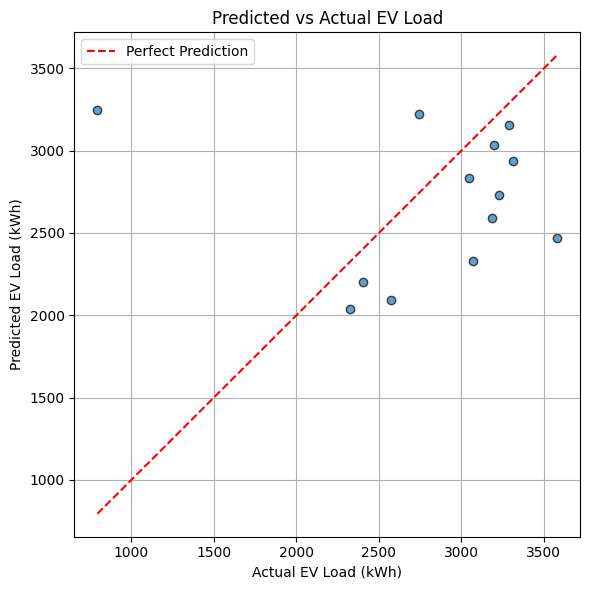

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_unscaled, y_pred, alpha=0.7, edgecolors='k')
plt.plot([min(y_test_unscaled), max(y_test_unscaled)],
         [min(y_test_unscaled), max(y_test_unscaled)],
         color='red', linestyle='--', label='Perfect Prediction')
plt.title("Predicted vs Actual EV Load")
plt.xlabel("Actual EV Load (kWh)")
plt.ylabel("Predicted EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


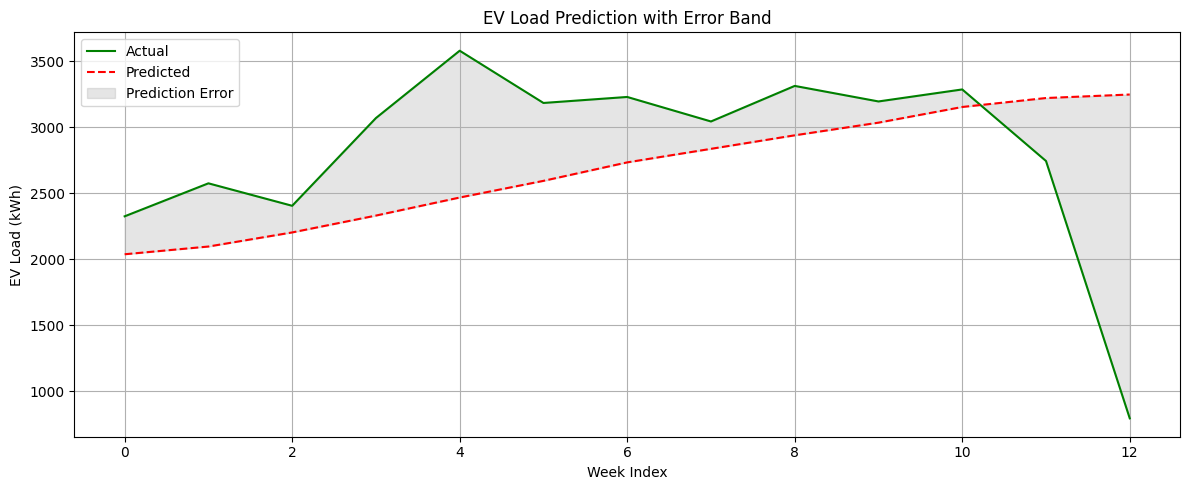

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual', color='green')
plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
plt.fill_between(range(len(y_pred)), y_pred.flatten(), y_test_unscaled.flatten(),
                 color='gray', alpha=0.2, label='Prediction Error')
plt.title("EV Load Prediction with Error Band")
plt.xlabel("Week Index")
plt.ylabel("EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


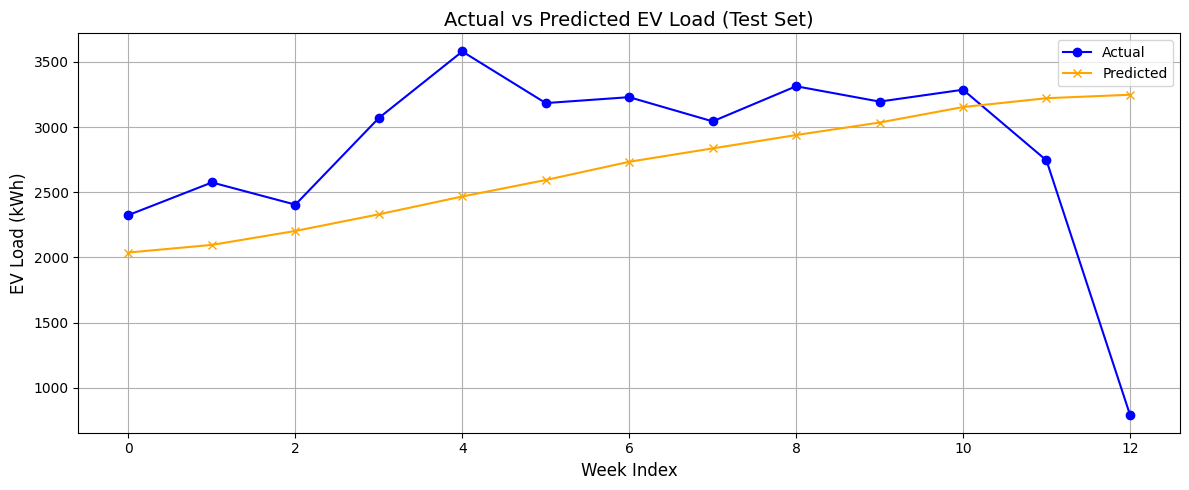

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_unscaled, label='Actual', color='blue', marker='o', linestyle='-')
plt.plot(y_pred, label='Predicted', color='orange', marker='x', linestyle='-')
plt.title("Actual vs Predicted EV Load (Test Set)", fontsize=14)
plt.xlabel("Week Index", fontsize=12)
plt.ylabel("EV Load (kWh)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


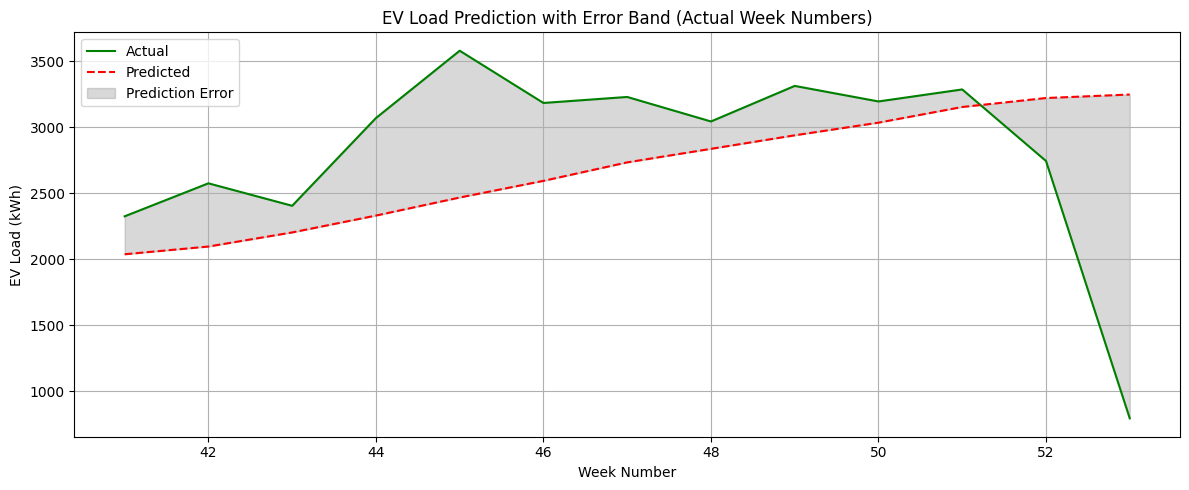

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract actual week numbers for the test set
week_labels = merged_df['week_num'].values[-len(y_test_unscaled):]

# Plot
plt.figure(figsize=(12, 5))
plt.plot(week_labels, y_test_unscaled, label='Actual', color='green')
plt.plot(week_labels, y_pred, label='Predicted', linestyle='--', color='red')

# Fill error band
error = np.abs(y_test_unscaled - y_pred)
plt.fill_between(week_labels.ravel(),
                 y_test_unscaled.ravel(),
                 y_pred.ravel(),
                 color='gray', alpha=0.3, label='Prediction Error')

# Labels and title
plt.title("EV Load Prediction with Error Band (Actual Week Numbers)")
plt.xlabel("Week Number")
plt.ylabel("EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


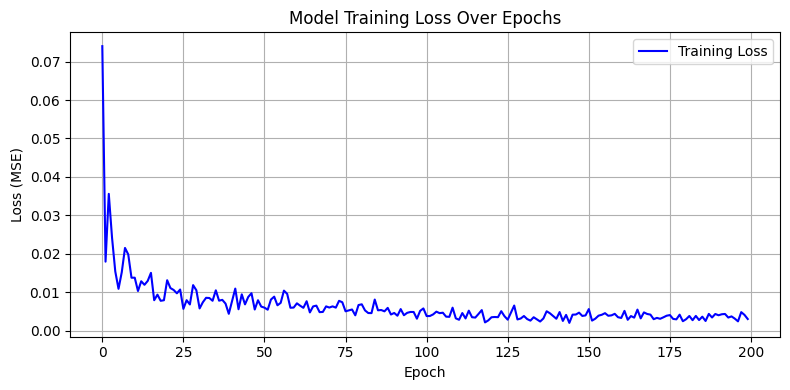

In [ ]:
# === Plot Training Loss ===
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.title('Model Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Re-Test

In [ ]:
# Reuse the full data (X_scaled, y_scaled) and create sequences
X_full_seq = []
for i in range(lookback, len(X_scaled)):
    X_full_seq.append(X_scaled[i - lookback:i])

X_full_seq = np.array(X_full_seq)


In [ ]:
# Predict
y_pred_full_scaled = model.predict(X_full_seq)
y_pred_full = scaler_y.inverse_transform(y_pred_full_scaled)

# Actual values (unscaled)
y_actual_full = scaler_y.inverse_transform(y_scaled[lookback:])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 


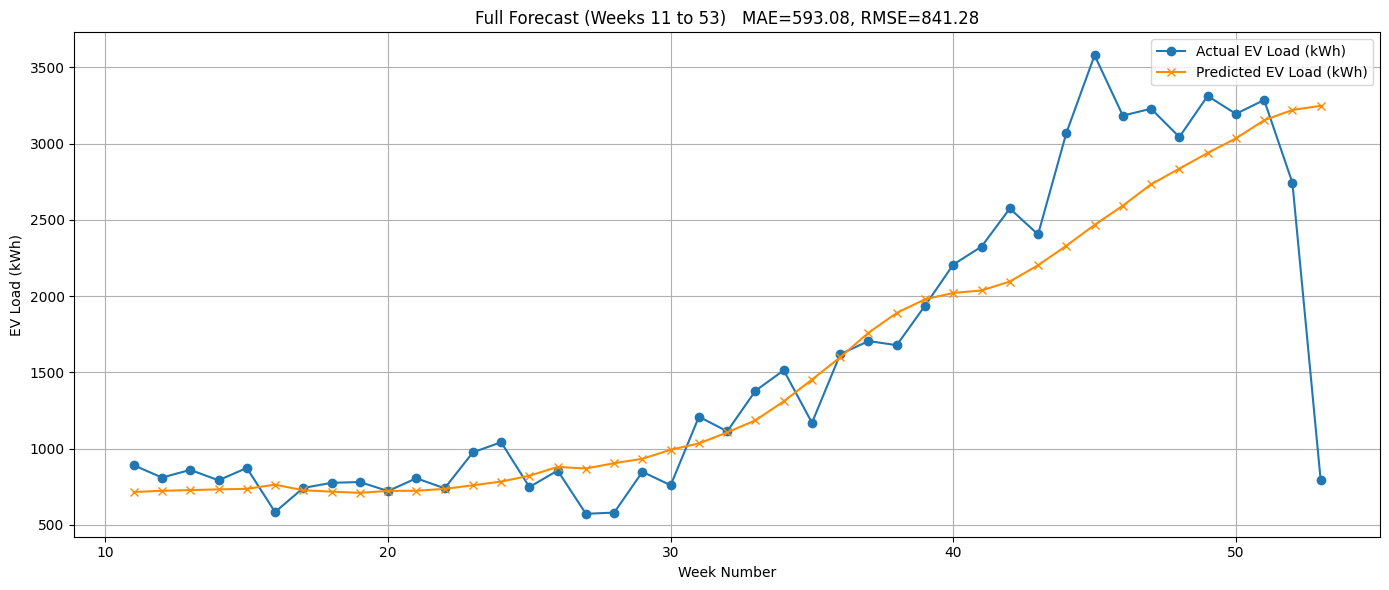

In [ ]:
# Reconstruct week labels from lookback onward
week_labels = np.arange(lookback, lookback + len(y_pred_full)) + 1  # Adjust +1 if needed

# Convert predictions to 1D
y_actual_full = np.array(y_actual_full).flatten()
y_pred_full = np.array(y_pred_full).flatten()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(week_labels, y_actual_full, label='Actual EV Load (kWh)', marker='o', linestyle='-', color='tab:blue')
plt.plot(week_labels, y_pred_full, label='Predicted EV Load (kWh)', marker='x', linestyle='-', color='darkorange')

plt.title(f"Full Forecast (Weeks {week_labels[0]} to {week_labels[-1]})   MAE={mae:.2f}, RMSE={rmse:.2f}")
plt.xlabel("Week Number")
plt.ylabel("EV Load (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Actual vs Predicted Scatter Plot')

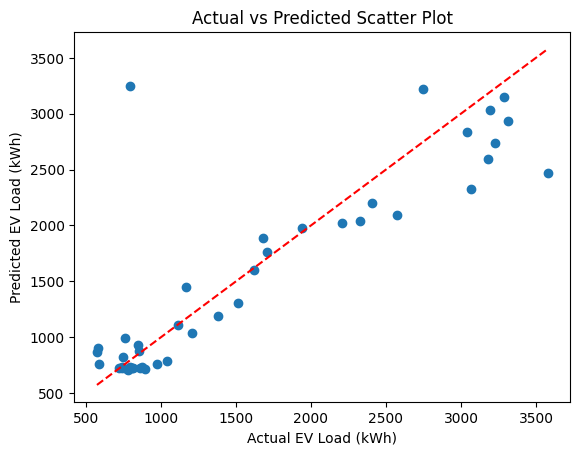

In [ ]:
plt.scatter(y_actual_full, y_pred_full)
plt.plot([min(y_actual_full), max(y_actual_full)],
         [min(y_actual_full), max(y_actual_full)], 'r--')  # Ideal line
plt.xlabel("Actual EV Load (kWh)")
plt.ylabel("Predicted EV Load (kWh)")
plt.title("Actual vs Predicted Scatter Plot")


Text(0, 0.5, 'Loss (MSE or MAE)')

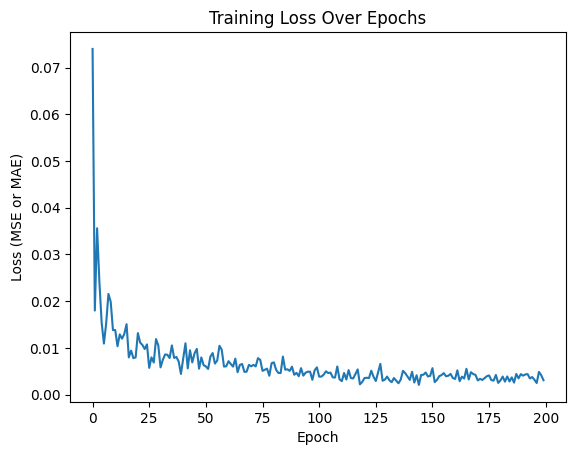

In [ ]:
plt.plot(history.history['loss'])
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE or MAE)")


<Axes: >

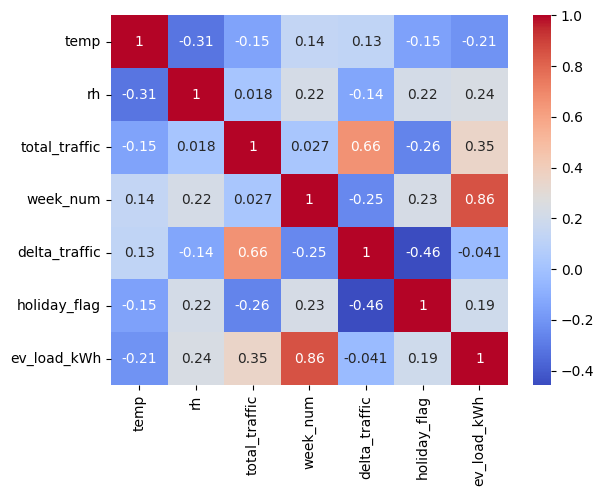

In [ ]:
import seaborn as sns
corr = merged_df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
